# Updates

In [1]:
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"

In [6]:
from scripts.tweet_scheduler import sched

In [ ]:
print ('Instantiate Exception Logger')
filename = 'twitter-{}.log'.format(dt.now().strftime('%Y-%m-%d'))
logfile = config('TWEETLOG_PATH') + filename
exc_logger = ExceptionLogger(logfile)

In [ ]:
wrapped_chart = exc_logger.wrap()(tweetbot.count_comparison)
wrapped_chart(casestudy, count_type, regions)

In [ ]:
def wrap(self, level='exception'):
    """
    Decorator for catching and logging exceptions for whatever function is called
    Applied using traditional syntax of func = exc_wrap(level)(func)
    """
    assert level in ['exception', 'critical']

    def decorator(func):                
        @functools.wraps(func)
        def log_exception(*args, **kwargs):

            try:
                result = func(*args, **kwargs)
                return result
            except Exception as e:
                print (repr(e))
                if level == 'exception':
                    logging.exception(func.__name__ + str(e))
                elif level == 'critical':
                    logging.critical(func.__name__ + str(e))
        return log_exception
    return decorator

hello!!!!
Getting See19 Baseframe
Instantiate Exception Logger***********************] Downloading ... COMPLETE
Instantiate casestudy
Instantiate TweetBot
Creating Case and Fatality comparisons for ...
	Texas Alabama Arizona


	Georgia Tennessee Florida


	California Florida Washington


	Illinois Ohio Massachusetts


	British Columbia Ontario New South Wales


	Sweden Norway Finland Denmark


	Spain Germany France


	Lombardia New York New Jersey


	Sao Paulo Rio De Janeiro


	Hong Kong Singapore


	Japan Malaysia Korea, South


Creating Wave Analysis for ..


/Users/spindicate/Documents/programming/zooscraper/casestudy/covidcharts/tweetbot.py:214: RuntimeWarning: invalid value encountered in double_scalars
  test_med = end_comp / start_comp
/Users/spindicate/Documents/programming/zooscraper/casestudy/covidcharts/tweetbot.py:215: RuntimeWarning: invalid value encountered in double_scalars
  test_far = end_comp / stretch_comp
/Users/spindicate/Documents/programming/zooscraper/casestudy/covidcharts/tweetbot.py:216: RuntimeWarning: invalid value encountered in double_scalars
  test_close = end_comp / close_comp
/Users/spindicate/Documents/programming/zooscraper/casestudy/covidcharts/tweetbot.py:214: RuntimeWarning: divide by zero encountered in double_scalars
  test_med = end_comp / start_comp
/Users/spindicate/Documents/programming/zooscraper/casestudy/covidcharts/tweetbot.py:216: RuntimeWarning: divide by zero encountered in double_scalars
  test_close = end_comp / close_comp
/Users/spindicate/Documents/programming/zooscraper/casestudy/covidc

	ex_BRA: peak_wave


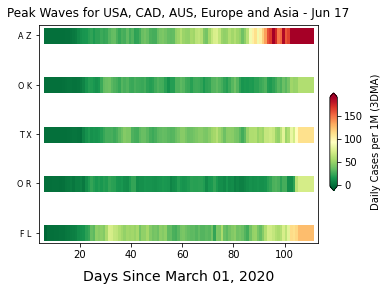

	ex_BRA: sustained_wave


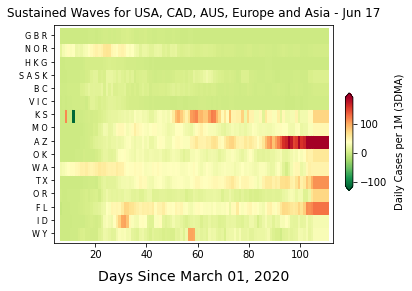

	ex_BRA: weak_wave

            Wave Update for New Cases. Out of 104 regions in USA, CAD, AUS, Europe and Asia, 52 regions are experiencing a weak wave, 16 are experiencing a sustained wave, and 5 are peaking. 
            
	ex_BRA: peak_wave
	ex_BRA: sustained_wave


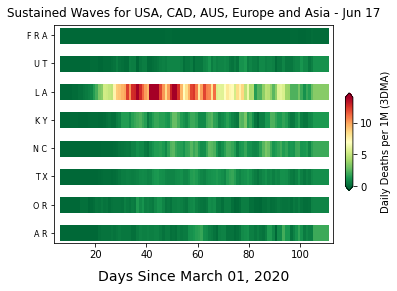

	ex_BRA: weak_wave

            Wave Update for New Deaths. Out of 104 regions in USA, CAD, AUS, Europe and Asia, 21 regions are experiencing a weak wave, 8 are experiencing a sustained wave, and 0 are peaking. 
            
	BRA: peak_wave


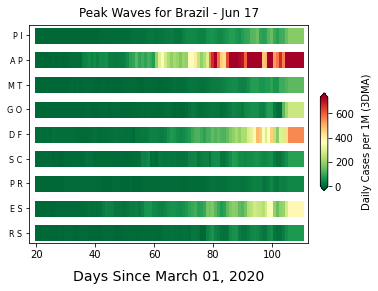

	BRA: sustained_wave


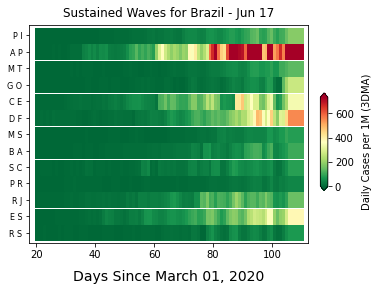

	BRA: weak_wave


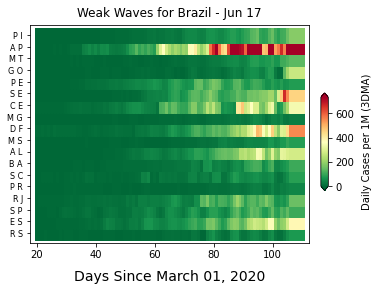


            Wave Update for New Cases. Out of 27 regions in Brazil, 18 regions are experiencing a weak wave, 13 are experiencing a sustained wave, and 9 are peaking. 
            
	BRA: peak_wave


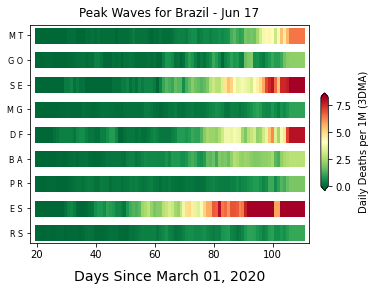

	BRA: sustained_wave


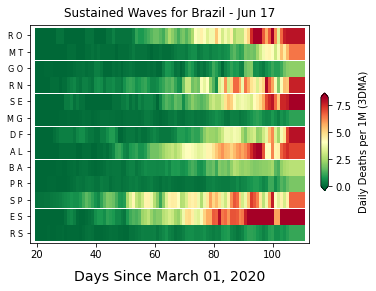

	BRA: weak_wave


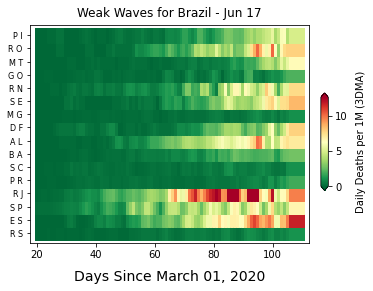


            Wave Update for New Deaths. Out of 27 regions in Brazil, 16 regions are experiencing a weak wave, 13 are experiencing a sustained wave, and 9 are peaking. 
            
Instantiating US CaseStudy
Printing Positivity Bar ...
TweepError([{'message': 'Over capacity', 'code': 130}])
Making Positivity Race ...


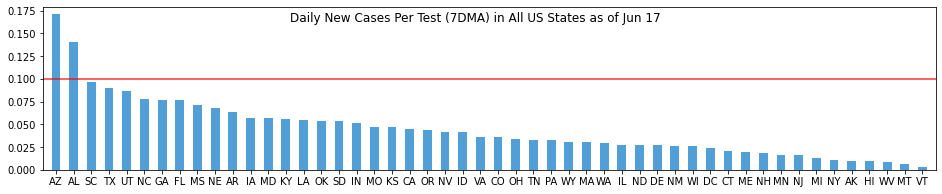

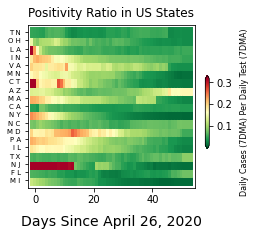

Instantiate country level CaseStudy for Strindex
Printing Global strindex race


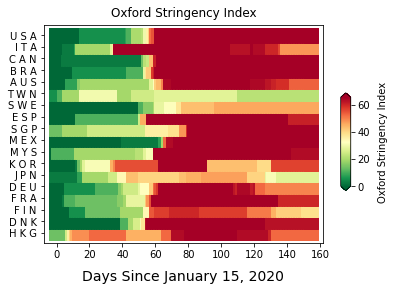

KeyboardInterrupt: 

In [7]:
from contextlib import contextmanager

@contextmanager
def catch(name):
    try:
        f = open(name, 'w')
        yield f
    finally:
        f.close()

with managed_file('hello.txt') as f:
    f.write('hello, world!')
    f.write('bye now')